

---

## Hand Sign Classification using Deep Learning

This code demonstrates how to build a deep learning model for classifying hand signs into six different classes. The dataset is loaded from h5py files and preprocessed before training the model. The model architecture consists of a three-layer neural network with ReLU activation functions. The training process uses gradient descent with the stochastic gradient descent (SGD) optimizer and the Adam optimizer, allowing for a comparison of performance. Additionally, a CNN model is implemented using the Keras Sequential API.

### Steps in the Code:

1. **Load and Preprocess Dataset:** The code loads the hand sign dataset from h5py files and preprocesses the images and labels. It also performs one-hot encoding of the labels for training the neural network.

2. **Neural Network Model:** A three-layer neural network model is defined using TensorFlow. The model consists of two hidden layers with ReLU activation functions and an output layer with a softmax activation function for multi-class classification.

3. **Training the Neural Network:** The model is trained using the training dataset. The training function implements gradient descent and updates the model's parameters to minimize the cross-entropy loss.

4. **CNN Model:** A Convolutional Neural Network (CNN) model is implemented using the Keras Sequential API. The CNN model consists of three convolutional layers, followed by max-pooling layers, and a fully connected layer with softmax activation for multi-class classification.

5. **Training the CNN Model:** The CNN model is compiled with an Adam optimizer and categorical cross-entropy loss. It is then trained using the normalized training data.

6. **Real-time Hand Sign Classification using Webcam:** The code captures frames from the webcam feed and preprocesses the images to match the input size of the CNN model. It then makes predictions using the trained CNN model and displays the predicted class label on the frame.

7. **Evaluation on Test Dataset:** The code evaluates the trained CNN model on the test dataset and plots the test samples with their predicted class labels. It also indicates whether the prediction is correct or incorrect on each image.

### Requirements:

- TensorFlow
- h5py
- numpy
- matplotlib
- OpenCV (cv2)

---

Please note that this is a high-level description of the code. For more specific details and implementation, refer to the code comments and explanations in the previous conversation.

In [2]:
import h5py 
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time

In [3]:
tf.__version__

'2.10.1'

In [4]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("No GPU devices found.")
else:
    for gpu in physical_devices:
        print(f"GPU Name: {gpu.name}")
        print(f"GPU Type: {gpu.device_type}")
        try:
            tf.config.experimental.get_memory_growth(gpu)
            print("Memory Growth: True")
        except:
            print("Memory Growth: False")


GPU Name: /physical_device:GPU:0
GPU Type: GPU
Memory Growth: True


In [6]:
train_ds = h5py.File('train_signs.h5',"r")
test_ds = h5py.File('test_signs.h5',"r")

In [7]:
type(train_ds)
print ( list(train_ds.keys()))

['list_classes', 'train_set_x', 'train_set_y']


In [53]:
train_set_x = train_ds['train_set_x'][:]
train_set_y = train_ds['train_set_y'][:]
test_set_x = test_ds['test_set_x'][:]
test_set_y = test_ds['test_set_y'][:]
list_classes = train_ds['list_classes'][:]

In [54]:
print ('Shape of the train_set Featurs is :' ,train_set_x.shape )
print ('Shape of the train_set_y Featurs is :' ,train_set_y.shape )
print ('Shape of the train_set Featurs is :' ,test_set_x.shape )
print ('Shape of the train_set_y Featurs is :' ,test_set_y.shape )

Shape of the train_set Featurs is : (1080, 64, 64, 3)
Shape of the train_set_y Featurs is : (1080,)
Shape of the train_set Featurs is : (120, 64, 64, 3)
Shape of the train_set_y Featurs is : (120,)


In [55]:
x_train = tf.data.Dataset.from_tensor_slices(train_set_x)
y_train = tf.data.Dataset.from_tensor_slices(train_set_y)
x_test = tf.data.Dataset.from_tensor_slices(test_set_x)
y_test = tf.data.Dataset.from_tensor_slices(test_set_y)

In [11]:
type(x_train)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [16]:
normalizer = lambda image : tf.cast(image, tf.float32)/256.0 

In [17]:
new_train = x_train.map(normalizer)
new_test = x_test.map(normalizer)

In [18]:
new_train.element_spec

TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None)

In [19]:
print(next(iter(next(iter(new_train)))))

tf.Tensor([0.88671875], shape=(1,), dtype=float32)


In [20]:
def linear_function () : 
    X = tf.constant (np.random.rand (3,1))
    W = tf.constant(np.random.randn(4,3))
    b = tf.constant(np.random.randn(4,1))
    Y = tf.add(tf.matmul(W,X),b)
    return Y


In [21]:
result = linear_function()
print(result)

tf.Tensor(
[[-0.4149682 ]
 [-0.21092786]
 [ 0.32055831]
 [ 0.25336335]], shape=(4, 1), dtype=float64)


In [22]:
#one_hot encodeing 

In [23]:
sigmoid = lambda z : tf.keras.activations.sigmoid(tf.cast(z , tf.float32)) 
one_hot_matrix = lambda lable, depth = 6 : tf.reshape (tf.one_hot(lable ,depth,axis =0) , [depth,1])

In [24]:
label = tf.constant(0)
depth = 4
result = one_hot_matrix(label , depth)

In [25]:
result

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[1.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [26]:
new_y_test = y_test.map(one_hot_matrix)
new_y_train = y_train.map(one_hot_matrix)

In [27]:
print(next(iter(new_y_test)))

tf.Tensor(
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(6, 1), dtype=float32)


In [28]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with TensorFlow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
                                
    initializer = tf.keras.initializers.GlorotNormal(seed=1)   

    W1 = tf.Variable(initializer(shape=(25, 12288)))
    b1 = tf.Variable(initializer(shape=(25, 1)))
    W2 = tf.Variable(initializer(shape=(12, 25)))
    b2 = tf.Variable(initializer(shape=(12, 1)))
    W3 = tf.Variable(initializer(shape=(6,12)))
    b3 = tf.Variable(initializer(shape=(6, 1)))
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [29]:
parameters = initialize_parameters()

In [30]:
parameters

{'W1': <tf.Variable 'Variable:0' shape=(25, 12288) dtype=float32, numpy=
 array([[ 0.00183502, -0.00714326,  0.00914526, ..., -0.01221176,
          0.01656458,  0.00526992],
        [ 0.02264025,  0.0067227 ,  0.00795862, ...,  0.00284724,
          0.01910819,  0.00122853],
        [-0.00163333, -0.00861273, -0.01398893, ..., -0.00741132,
          0.02071251, -0.026417  ],
        ...,
        [-0.00126929,  0.01729332,  0.02082342, ...,  0.01709594,
          0.00429358, -0.00733263],
        [ 0.00275988,  0.00419503,  0.00949959, ...,  0.01241149,
         -0.0270652 ,  0.01501104],
        [-0.00145541,  0.02459595,  0.00339064, ..., -0.02478788,
          0.02716016, -0.00306428]], dtype=float32)>,
 'b1': <tf.Variable 'Variable:0' shape=(25, 1) dtype=float32, numpy=
 array([[ 0.03993344],
        [-0.15545043],
        [ 0.19901742],
        [-0.24872702],
        [-0.28688198],
        [-0.12585859],
        [-0.01201915],
        [ 0.14756493],
        [-0.00472601],
        

In [31]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)    # Z1 = np.dot(W1, X) + b1
    A1 = tf.keras.activations.relu(Z1) # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)   # Z2 = np.dot(W2, A1) + b2
    A2 = tf.keras.activations.relu(Z2) # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)   # Z3 = np.dot(W3, A2) + b3
    
    
    
    return Z3

In [32]:
def compute_cost(logits, labels):
    """
    Computes the cost
    
    Arguments:
    logits -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    labels -- "true" labels vector, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    cost = tf.reduce_mean(tf.keras.losses.binary_crossentropy(labels,logits,from_logits=True))
    return cost

In [33]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    costs = []                                        # To keep track of the cost

    parameters = initialize_parameters()

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    optimizer = tf.keras.optimizers.SGD(learning_rate)

    X_train = X_train.batch(minibatch_size, drop_remainder=True).prefetch(8)# <<< extra step    
    Y_train = Y_train.batch(minibatch_size, drop_remainder=True).prefetch(8) # loads memory faster 


    for epoch in range(num_epochs):

        epoch_cost = 0.
        
        for (minibatch_X, minibatch_Y) in zip(X_train, Y_train):
            # Select a minibatch
            with tf.GradientTape() as tape:
                # 1. predict
                Z3 = forward_propagation(minibatch_X, parameters)
                # 2. loss
                minibatch_cost = compute_cost(Z3, minibatch_Y)
                
            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_cost, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))
            epoch_cost += minibatch_cost / minibatch_size

        if print_cost == True and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
        if print_cost == True and epoch % 5 == 0:
            costs.append(epoch_cost)

    # Plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per fives)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    # Save the parameters in a variable
    print ("Parameters have been trained!")

    return parameters

Cost after epoch 0: 0.742591
Cost after epoch 10: 0.614557
Cost after epoch 20: 0.598900
Cost after epoch 30: 0.588907
Cost after epoch 40: 0.579898
Cost after epoch 50: 0.570628
Cost after epoch 60: 0.560898
Cost after epoch 70: 0.550808
Cost after epoch 80: 0.540497
Cost after epoch 90: 0.488141
Cost after epoch 100: 0.478272
Cost after epoch 110: 0.472865
Cost after epoch 120: 0.468991
Cost after epoch 130: 0.466015
Cost after epoch 140: 0.463661
Cost after epoch 150: 0.461677
Cost after epoch 160: 0.459951
Cost after epoch 170: 0.458392
Cost after epoch 180: 0.456970
Cost after epoch 190: 0.455647


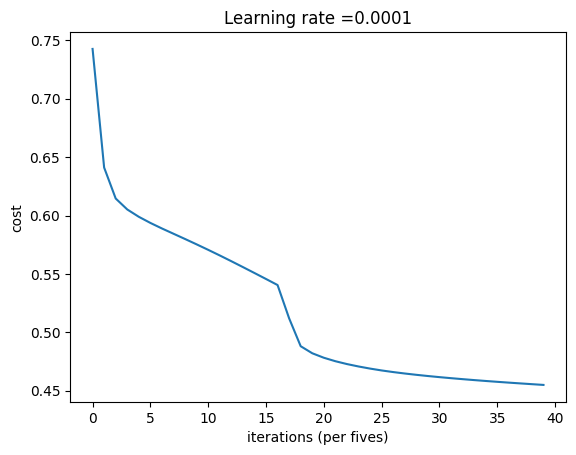

Parameters have been trained!


{'W1': <tf.Variable 'Variable:0' shape=(25, 12288) dtype=float32, numpy=
 array([[ 0.00159522, -0.00737918,  0.00893291, ..., -0.01227797,
          0.01642201,  0.00506484],
        [ 0.02264025,  0.0067227 ,  0.00795862, ...,  0.00284724,
          0.01910819,  0.00122853],
        [-0.00173583, -0.00872451, -0.01410439, ..., -0.00733834,
          0.02050859, -0.0268302 ],
        ...,
        [-0.00126929,  0.01729332,  0.02082342, ...,  0.01709594,
          0.00429358, -0.00733263],
        [ 0.00268257,  0.00410495,  0.00936706, ...,  0.01222281,
         -0.02717606,  0.01498352],
        [-0.00145541,  0.02459595,  0.00339064, ..., -0.02478788,
          0.02716016, -0.00306428]], dtype=float32)>,
 'b1': <tf.Variable 'Variable:0' shape=(25, 1) dtype=float32, numpy=
 array([[ 0.03964256],
        [-0.15545043],
        [ 0.19885883],
        [-0.24874453],
        [-0.2867674 ],
        [-0.12604605],
        [-0.01213097],
        [ 0.14784044],
        [-0.0041317 ],
        

In [34]:
model(new_train, new_y_train, new_test, new_y_test, num_epochs=200)


In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001,
          num_epochs=1500, minibatch_size=32, print_cost=True,
          optimizer_type="SGD", keep_prob=1.0):  # Keep prob is the probability to keep a neuron active during training
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.

    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    optimizer_type -- String, either "SGD" or "Adam"
    keep_prob -- Float, the probability to keep a neuron active during training (dropout)

    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

     
    costs = []                                        # To keep track of the cost

    parameters = initialize_parameters()

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    optimizer = tf.keras.optimizers.SGD(learning_rate)

    X_train = X_train.batch(minibatch_size, drop_remainder=True).prefetch(8)# <<< extra step    
    Y_train = Y_train.batch(minibatch_size, drop_remainder=True).prefetch(8) # loads memory faster 

    # Create the optimizer based on the selected type
    if optimizer_type == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate)
    elif optimizer_type == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate)
    else:
        raise ValueError("Invalid optimizer_type. Supported values are 'SGD' and 'Adam'.")

    # Rest of the code remains the same as before...

    for epoch in range(num_epochs):

        epoch_cost = 0.

        for (minibatch_X, minibatch_Y) in zip(X_train, Y_train):
            # Select a minibatch
            with tf.GradientTape() as tape:
                # 1. predict
                Z3 = forward_propagation(minibatch_X, parameters)
                # 2. loss
                minibatch_cost = compute_cost(Z3, minibatch_Y)

            trainable_variables = [W1, b1, W2, b2, W3, b3]

            # Applying dropout during training
            if keep_prob < 1.0:
                dropout_mask = tf.random.uniform(minibatch_X.shape) < keep_prob
                scaled_mask = tf.cast(dropout_mask, dtype=tf.float32) / keep_prob
                minibatch_X *= scaled_mask

            grads = tape.gradient(minibatch_cost, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))
            epoch_cost += minibatch_cost / minibatch_size

        if print_cost == True and epoch % 10 == 0:
            print("Cost after epoch %i: %f" % (epoch, epoch_cost))
        if print_cost == True and epoch % 5 == 0:
            costs.append(epoch_cost)

    # Plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per fives)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    # Save the parameters in a variable
    print("Parameters have been trained!")

    return parameters


Cost after epoch 0: 0.742591
Cost after epoch 10: 0.614557
Cost after epoch 20: 0.598900
Cost after epoch 30: 0.588907
Cost after epoch 40: 0.579898
Cost after epoch 50: 0.570628
Cost after epoch 60: 0.560898
Cost after epoch 70: 0.550808
Cost after epoch 80: 0.540497
Cost after epoch 90: 0.488141
Cost after epoch 100: 0.478272
Cost after epoch 110: 0.472865
Cost after epoch 120: 0.468991
Cost after epoch 130: 0.466015
Cost after epoch 140: 0.463661
Cost after epoch 150: 0.461677
Cost after epoch 160: 0.459951
Cost after epoch 170: 0.458392
Cost after epoch 180: 0.456970
Cost after epoch 190: 0.455647


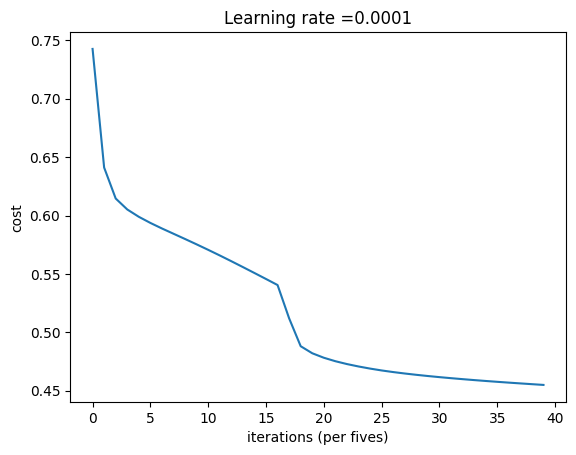

Parameters have been trained!
Cost after epoch 0: 0.610249
Cost after epoch 10: 0.446378
Cost after epoch 20: 0.402015
Cost after epoch 30: 0.370229
Cost after epoch 40: 0.346389
Cost after epoch 50: 0.325712
Cost after epoch 60: 0.308065
Cost after epoch 70: 0.292801
Cost after epoch 80: 0.278907
Cost after epoch 90: 0.266238
Cost after epoch 100: 0.254521
Cost after epoch 110: 0.243655
Cost after epoch 120: 0.233230
Cost after epoch 130: 0.223727
Cost after epoch 140: 0.214601
Cost after epoch 150: 0.206288
Cost after epoch 160: 0.198552
Cost after epoch 170: 0.191492
Cost after epoch 180: 0.184612
Cost after epoch 190: 0.178532


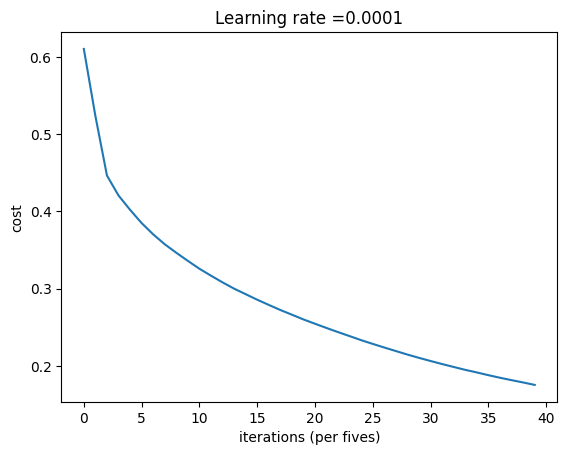

Parameters have been trained!
Cost after epoch 0: 0.742591
Cost after epoch 10: 0.614557
Cost after epoch 20: 0.598900
Cost after epoch 30: 0.588907
Cost after epoch 40: 0.579898
Cost after epoch 50: 0.570628
Cost after epoch 60: 0.560898
Cost after epoch 70: 0.550808
Cost after epoch 80: 0.540497
Cost after epoch 90: 0.488141
Cost after epoch 100: 0.478272
Cost after epoch 110: 0.472865
Cost after epoch 120: 0.468991
Cost after epoch 130: 0.466015
Cost after epoch 140: 0.463661
Cost after epoch 150: 0.461677
Cost after epoch 160: 0.459951
Cost after epoch 170: 0.458392
Cost after epoch 180: 0.456970
Cost after epoch 190: 0.455647


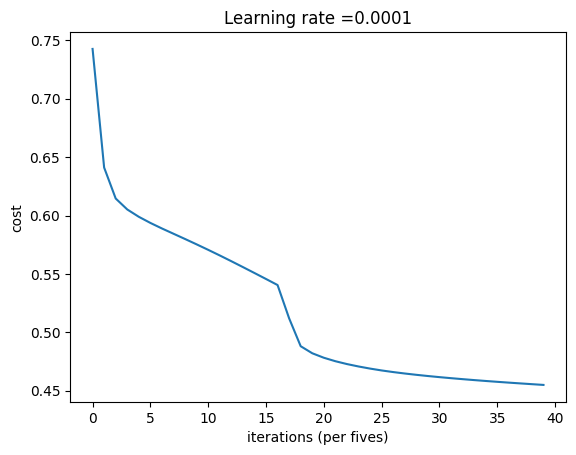

Parameters have been trained!


In [36]:
# Assuming you have already loaded the data into X_train, Y_train, X_test, and Y_test

# Scenario 1: Using "SGD" optimizer without dropout (keep_prob = 1.0)
parameters_sgd = model(new_train, new_y_train, new_test, new_y_test, learning_rate=0.0001,
                       num_epochs=200, minibatch_size=32, print_cost=True,
                       optimizer_type="SGD", keep_prob=1.0)

# Scenario 2: Using "Adam" optimizer without dropout (keep_prob = 1.0)
parameters_adam = model(new_train, new_y_train, new_test, new_y_test, learning_rate=0.0001,
                        num_epochs=200, minibatch_size=32, print_cost=True,
                        optimizer_type="Adam", keep_prob=1.0)
 
# Scenario 3: Using "SGD" optimizer with dropout (keep_prob = 0.8)
parameters_sgd_dropout = model(new_train, new_y_train, new_test, new_y_test, learning_rate=0.0001,
                              num_epochs=200, minibatch_size=32, print_cost=True,
                              optimizer_type="SGD", keep_prob=0.8)


In [38]:
prediction = lambda X , parameters: np.argmax (forward_propagation(X , parameters),axis = 0 )

In [39]:
def test (X_test , Y_test , params ) : 
    y = []
    for X , Y  in zip (X_test ,Y_test): 
        y_prime  = prediction(X , params)
        y.append(y_prime == Y)
        print (y_prime == Y)

    accuracy = np.sum (y) / len(y)
    return accuracy


In [40]:
test (new_test , y_test , parameters_adam ) 

tf.Tensor([False], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([

0.775

In [41]:
import cv2
import tensorflow as tf
import numpy as np

# Load the trained model and its parameters
# Replace 'path_to_model' with the actual path to your saved model

# Preprocess the image to match the input size and format of the model
def preprocess_image(image):
    # Resize the image to the model's input shape (e.g., 64x64 pixels)
    resized_image = cv2.resize(image, (64, 64))
    # Convert the image to RGB (if it's in BGR format)
    rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    # Normalize the pixel values to be in the range [0, 1]
    normalized_image = rgb_image / 255.0
    # Expand the dimensions to match the model's input shape (e.g., add batch dimension)
    input_image = np.expand_dims(normalized_image, axis=0)
    input_image = tf.reshape(input_image, [1, 64*64*3]).numpy().T
    print(input_image.shape)

    return input_image

# Access the webcam feed
cap = cv2.VideoCapture(0)  # Use 0 for the default webcam, you can change the number if you have multiple cameras

while True:
    # Capture a frame from the webcam feed
    ret, frame = cap.read()

    # Preprocess the frame
    input_image = preprocess_image(frame)

    # Make predictions using the model
    predictionS = prediction(input_image,parameters_adam)
    # Assuming the model predicts the class probabilities, get the index of the class with the highest probability


    # Display the predicted class label on the frame
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2
    text = f"Predicted: {predictionS}"
    bottom_left_corner = (10, 30)
    text_color = (255, 0, 0)  # Blue color
    cv2.putText(frame, text, bottom_left_corner, font, font_scale, text_color, font_thickness)

    # Display the frame with the predicted class label
    cv2.imshow('Sign Classification', frame)

    # Stop the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close the display window
cap.release()
cv2.destroyAllWindows()


(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)
(12288, 1)

KeyboardInterrupt: 

In [75]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models

def CNN_Model (input_shape , Num_of_classes ) : 


    model = models.Sequential ( [
        layers.Conv2D (32 , (3,3), activation = 'relu', input_shape = input_shape ) , 
        layers.MaxPooling2D ((2,2)) , 
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(Num_of_classes, activation='softmax')
    ])
    return model 
input_shape = ( 64, 64, 3)  # Assuming you are using 64x64x3 images
num_classes = 6  # Replace this with the actual number of hand sign classes

# Create the CNN model
cnn_model = CNN_Model(input_shape, num_classes)

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Print the model summary
cnn_model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 6, 6, 128)      

In [76]:
for i in train_set_y :
    print(i)

5
0
2
5
2
4
2
1
1
4
2
1
5
5
2
5
2
4
0
4
0
0
3
3
1
3
2
3
5
5
4
0
3
2
0
4
1
1
2
4
1
5
0
4
1
0
3
1
1
5
0
3
0
0
5
2
0
2
2
1
4
3
0
5
2
1
0
4
3
2
1
4
2
4
4
2
5
4
5
4
2
1
5
3
4
0
1
3
3
5
4
0
1
5
1
5
1
4
3
5
3
3
2
0
5
1
1
2
4
4
2
2
5
2
4
2
1
1
5
5
5
1
5
1
0
2
1
1
2
2
4
5
3
0
0
0
0
2
4
3
1
4
0
1
2
0
1
0
3
0
3
0
3
2
0
4
0
4
0
5
2
0
5
5
0
4
3
4
4
4
1
5
1
0
1
3
2
0
5
4
1
3
2
3
0
0
3
2
4
3
4
3
3
1
0
2
4
0
3
4
1
5
2
0
3
0
2
5
4
5
2
4
3
1
2
5
5
2
4
5
1
5
2
4
2
4
3
5
3
1
0
0
1
2
5
1
4
3
3
5
1
0
4
3
0
1
2
1
4
4
1
2
5
1
0
4
1
3
2
5
4
1
4
1
2
2
0
0
1
0
2
0
0
2
4
4
3
1
4
5
3
1
0
0
2
5
1
0
1
3
3
0
1
3
5
5
0
1
1
4
5
0
0
1
2
5
4
1
3
5
5
5
1
4
1
0
5
3
0
2
4
2
2
2
1
5
2
3
0
3
2
0
0
1
5
1
5
2
1
3
3
3
3
4
2
2
0
3
1
2
4
0
5
1
1
3
2
0
4
3
3
3
3
0
4
0
4
5
4
3
5
2
5
3
4
4
1
5
5
4
0
3
4
1
3
3
3
2
1
1
3
2
0
3
1
1
3
0
1
2
0
0
0
1
0
3
5
0
4
0
2
4
0
2
3
2
3
3
1
4
2
3
2
3
4
4
4
4
1
0
0
3
3
2
5
0
3
1
0
5
1
5
2
1
3
3
4
3
0
5
1
5
2
2
4
2
4
3
4
2
2
5
4
4
1
2
0
5
1
2
4
5
4
4
0
1
3
2
0
2
0
3
5
2
5
1
2
3
5
3
5
5
1
5
0
2
3
0
4
1


In [79]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_set_x/255, (train_set_y)/255))
train_dataset = train_dataset.shuffle(buffer_size=len(train_set_x))
batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
cnn_model.fit(train_dataset, epochs=10 )

Epoch 1/10
34/34 [==============================] - 1s 31ms/step - loss: 0.0000e+00 - accuracy: 0.1667
Epoch 2/10
34/34 [==============================] - 1s 30ms/step - loss: 0.0000e+00 - accuracy: 0.1667
Epoch 3/10
34/34 [==============================] - 1s 24ms/step - loss: 0.0000e+00 - accuracy: 0.1667
Epoch 4/10
34/34 [==============================] - 1s 24ms/step - loss: 0.0000e+00 - accuracy: 0.1667
Epoch 5/10
34/34 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 0.1667
Epoch 6/10
34/34 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 0.1667
Epoch 7/10
34/34 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 0.1667
Epoch 8/10
34/34 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 0.1667
Epoch 9/10
34/34 [==============================] - 1s 26ms/step - loss: 0.0000e+00 - accuracy: 0.1667
Epoch 10/10
34/34 [==============================] - 1s 25ms/step - loss:

In [81]:
X_train = train_ds['train_set_x'][:]
y_train = train_ds['train_set_y'][:]
X_test = test_ds['test_set_x'][:]
y_test = test_ds['test_set_y'][:]
list_classes = train_ds['list_classes'][:]

In [82]:
# Normalize the data
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0

# Convert labels to one-hot encoding
num_classes = 6
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes)


In [84]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
batch_size = 32
epochs = 20
model.fit(X_train_normalized, y_train_one_hot, batch_size=batch_size, epochs=epochs)


Epoch 1/20
34/34 [==============================] - 2s 25ms/step - loss: 1.7914 - accuracy: 0.1815
Epoch 2/20
34/34 [==============================] - 1s 23ms/step - loss: 1.5252 - accuracy: 0.3843
Epoch 3/20
34/34 [==============================] - 1s 27ms/step - loss: 1.1710 - accuracy: 0.5352
Epoch 4/20
34/34 [==============================] - 1s 25ms/step - loss: 0.7979 - accuracy: 0.7157
Epoch 5/20
34/34 [==============================] - 1s 23ms/step - loss: 0.6210 - accuracy: 0.7917
Epoch 6/20
34/34 [==============================] - 1s 27ms/step - loss: 0.4951 - accuracy: 0.8352
Epoch 7/20
34/34 [==============================] - 1s 26ms/step - loss: 0.3608 - accuracy: 0.8759
Epoch 8/20
34/34 [==============================] - 1s 25ms/step - loss: 0.2811 - accuracy: 0.9019
Epoch 9/20
34/34 [==============================] - 1s 26ms/step - loss: 0.2254 - accuracy: 0.9269
Epoch 10/20
34/34 [==============================] - 1s 36ms/step - loss: 0.1724 - accuracy: 0.9519
Epoch 11/

In [86]:
import cv2
import tensorflow as tf
import numpy as np

# Load the trained model and its parameters
# Replace 'path_to_model' with the actual path to your saved model

# Preprocess the image to match the input size and format of the model
def preprocess_image(image):
    # Resize the image to the model's input shape (e.g., 64x64 pixels)
    resized_image = cv2.resize(image, (64, 64))
    # Convert the image to RGB (if it's in BGR format)
    rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    # Normalize the pixel values to be in the range [0, 1]
    normalized_image = rgb_image / 255.0
    # Expand the dimensions to match the model's input shape (e.g., add batch dimension)
    input_image = np.expand_dims(normalized_image, axis=0)
    return input_image

# Access the webcam feed
cap = cv2.VideoCapture(0)  # Use 0 for the default webcam, you can change the number if you have multiple cameras

while True:
    # Capture a frame from the webcam feed
    ret, frame = cap.read()

    # Preprocess the frame
    input_image = preprocess_image(frame)

    # Make predictions using the model
    prediction = model.predict(input_image)
    predicted_class_index = np.argmax(prediction)

    # Get the class label (you need to define your own class labels based on your sign classification problem)
    class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']
    predicted_class_label = class_labels[predicted_class_index]

    # Display the predicted class label on the frame
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2
    text = f"Predicted: {predicted_class_label}"
    bottom_left_corner = (10, 30)
    text_color = (255, 0, 0)  # Blue color
    cv2.putText(frame, text, bottom_left_corner, font, font_scale, text_color, font_thickness)

    # Display the frame with the predicted class label
    cv2.imshow('Hand Sign Classification', frame)

    # Stop the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close the display window
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 31ms/step


KeyboardInterrupt: 

4/4 [==============================] - 0s 32ms/step


ValueError: num must be an integer with 1 <= num <= 25, not 26

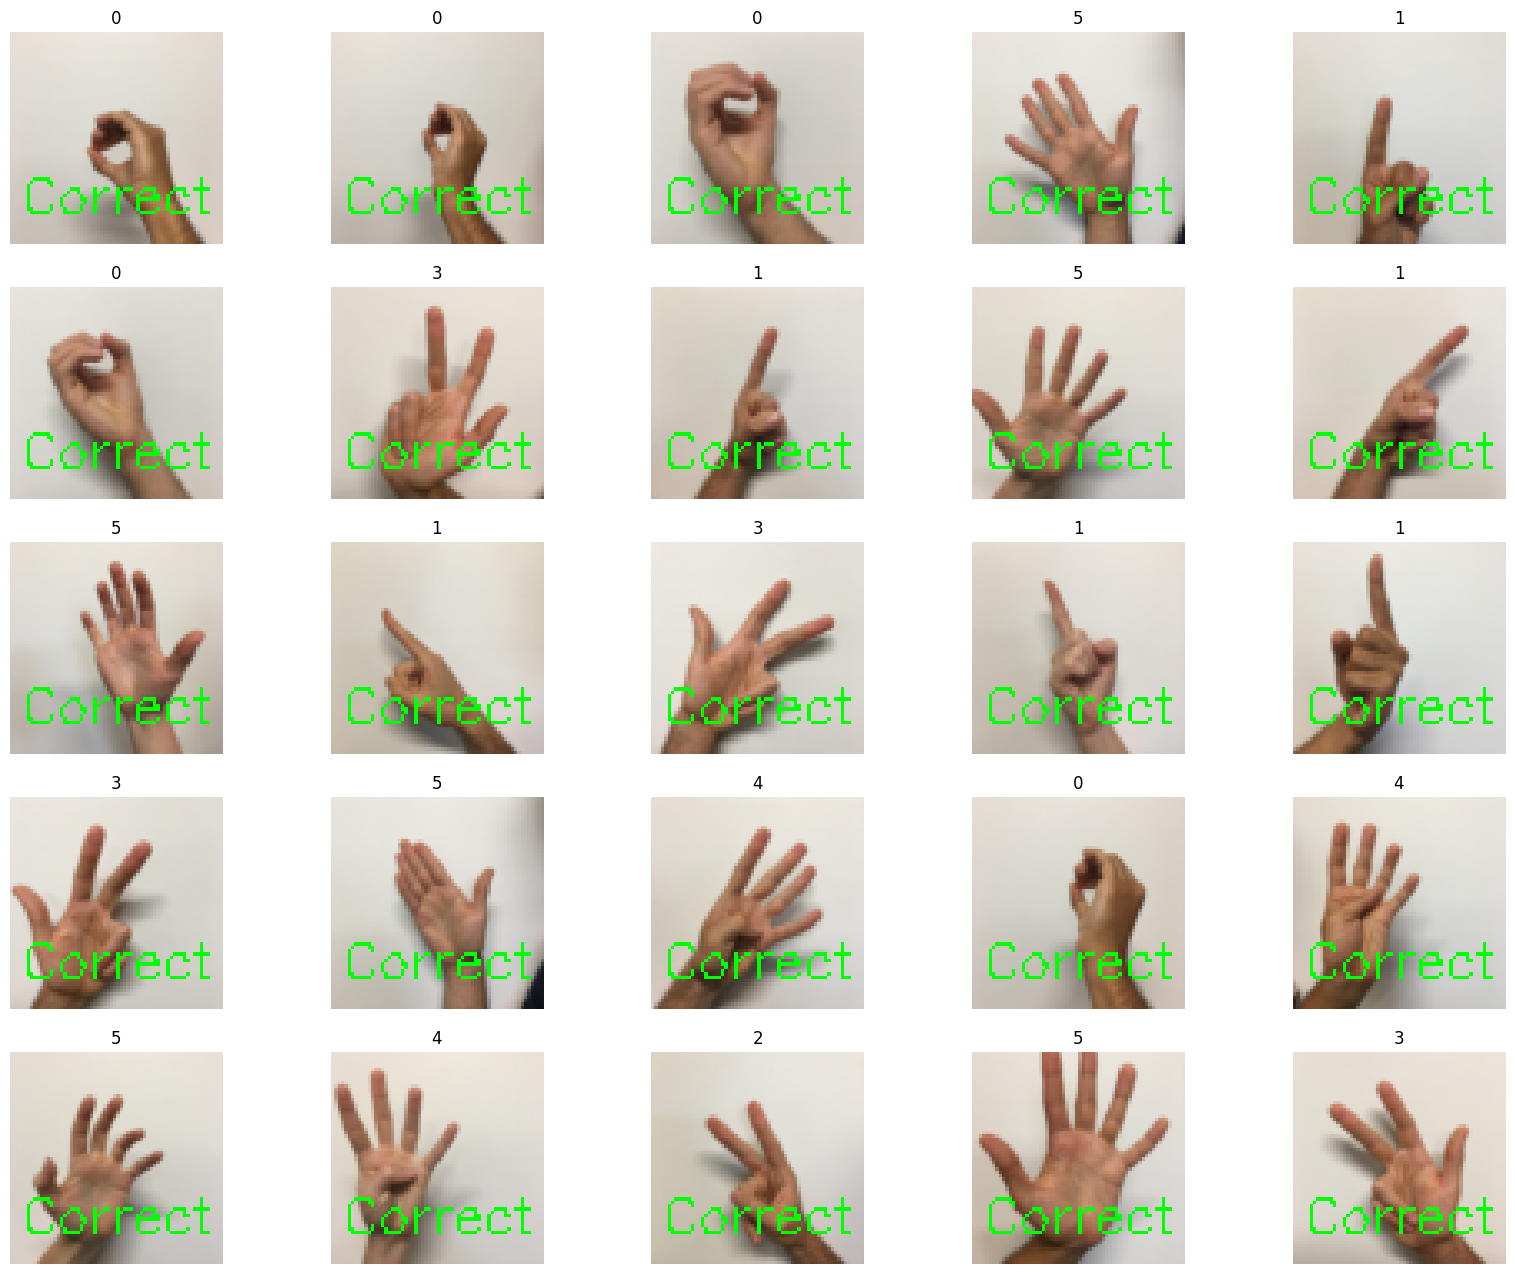

In [99]:
import h5py
import numpy as np
import matplotlib.pyplot as plt


# Preprocess the test data (if needed)
# For example, normalize the pixel values to be in the range [0, 1]

# Use the trained model to make predictions on the test data
predictions = model.predict(X_test_normalized)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert y_test to one-hot encoding (if it's not already in that format)
num_classes = 6  # Replace with the actual number of classes in your dataset
y_test_onehot = np.eye(num_classes)[y_test.reshape(-1)]

# Compare the predicted labels with the true labels
correct_predictions = predicted_labels == np.argmax(y_test_onehot, axis=1)

# Create a function to add text to the image indicating correct or incorrect prediction
def add_text_to_image(image, is_correct):
    text = "Correct" if is_correct else "Incorrect"
    color = (0, 255, 0) if is_correct else (255, 0, 0)  # Green for correct, Red for incorrect
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_thickness = 1
    text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
    text_x = (image.shape[1] - text_size[0]) // 2
    text_y = image.shape[0] - 10
    cv2.putText(image, text, (text_x, text_y), font, font_scale, color, font_thickness)

# Plot the test samples along with the predicted class labels
plt.figure(figsize=(20, 16))
for i in range(X_test.shape[0]):
    plt.subplot(5, 5, i + 1)
    image = X_test[i].copy()
    add_text_to_image(image, correct_predictions[i] , )
    plt.imshow(image)
    plt.title(predicted_labels[i])
    plt.axis('off')

plt.tight_layout()
plt.savefig('hand_sign.png')
plt.show()
plt.savefig('hand_sign.png')
